In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Variable Dimension Models and Reversible Jump Algorithms

While the previous chapters have presented a general class of MCMC algorithms, there exist settings where they are not general enough. A particular case of such settings is that of variable dimension models. There, the parameter (and simulation) space is not well defined, being a finite or denumerable collection of unrelated subspaces. To have an MCMC algorithm moving within this collection of spaces requires more advanced tools, if only because of the associated measure theoretic subtleties. Section 11.1 motivates the use of variable dimension models in the setup of Bayesian model choice and model comparison, while Section 11.2 presents the general theory of reversible jump algorithms, which were tailored for these models. Section 11.3 examines further algorithms and methods related to this issue.

## 1 Variable Dimension Models

In general, a variable dimension model is, to quote Peter Green, “a model where one of the things you do not know is the number of things you do not know.” This means that the statistical model under consideration is not defined precisely enough for the dimension of the parameter space to be fixed. As detailed below in Section 11.1.1, this setting is closely associated with model selection, a collection of statistical procedures that are used at the early stage of a statistical analysis, namely, when the model to be used is not yet fully determined.

In addition to model construction, there are other situations where several models are simultaneously considered. For instance, this occurs in model checking, model comparison, model improvement, and model pruning, with many areas of application: variable selection in generalized linear models, change point determination in signal processing, object recognition in image analysis, coding identification in DNA analysis, dependence reconstruction in expert systems, and so on.

### Example 11.1: Mixture Modeling

Consider the dataset represented by the histogram of Figure 11.1, and also provided in Table 11.1 (see Problem 11.7). It consists of the velocities of 82 galaxies previously analyzed by Roeder (1992) and is often used as a benchmark example in mixture analysis (see, e.g., Chib 1995, Phillips and Smith 1996, Rafttery 1996, Richardson and Green 1997, or Robert and Mengersen 1999). The probabilistic model considered for the representation of this dataset is a Gaussian mixture model:

$$
M_k : x_i \sim \sum_{j=1}^k p_j \mathcal{N}(\mu_j, \sigma_j^2) \quad (i = 1, \dots, 82),
$$

but the index $k$, that is the number of components in the mixture (or of clusters of galaxies in, say, the sample), is under debate. It cannot therefore be arbitrarily fixed to, say, $k = 7$ for the statistical analysis of this dataset.

#### 11.1.1 Bayesian Model Choice

While the concept of a variable dimension model is loosely defined, we can give a more formal definition which mostly pertains to the important case of model selection.

**Definition 11.2 (Bayesian variable dimension model)** A variable dimension model is defined as a collection of models $(k = 1, \dots, K)$,

$$
M_k = \{f(x \mid \theta_k), \theta_k \in \Theta_k\},
$$

associated with a collection of priors on the parameters of these models, $\pi_k(\theta_k)$, and a prior distribution on the models $(k = 1, \dots, K)$,

$$
\pi(k), \quad k = 1, \dots, K.
$$

Note that we will also use the more concise notation $\pi_k(M_k) = \pi(k \mid M_k)$.

This is done in $N$ dimensions, where $n_k(\theta_k)$ is a density with respect to the counting measure on $\theta_k$. The function $\pi(k)$ is then a density with respect to Lebesgue measure on the union of spaces, $\theta \in \bigcup_k \Theta_k$.

From a Bayesian perspective, this representation of the problem implies that inference is formally completed. Indeed, once the prior and the model are defined, the model selected from the dataset $x$ is determined from the posterior probabilities

$$
p(M_k \mid x) = \frac{\pi(k) \int f(x \mid \theta_k, M_k) \pi_k(\theta_k) d\theta_k}{\sum_{j} \pi(j) \int f(x \mid \theta_j, M_j) \pi_j(\theta_j) d\theta_j},
$$

either taking the model with largest $p(M_k \mid x)$ or using model averaging through

$$
\sum p(M_k \mid x) \int f(x \mid \theta_k, M_k) \pi_k(\theta_k) d\theta_k,
$$

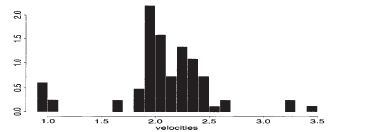


where $x$ denotes the observed dataset, as a predictive distribution, even though sophisticated decision theoretic perspectives could be adopted (see Robert, 2001, Chapter 7).

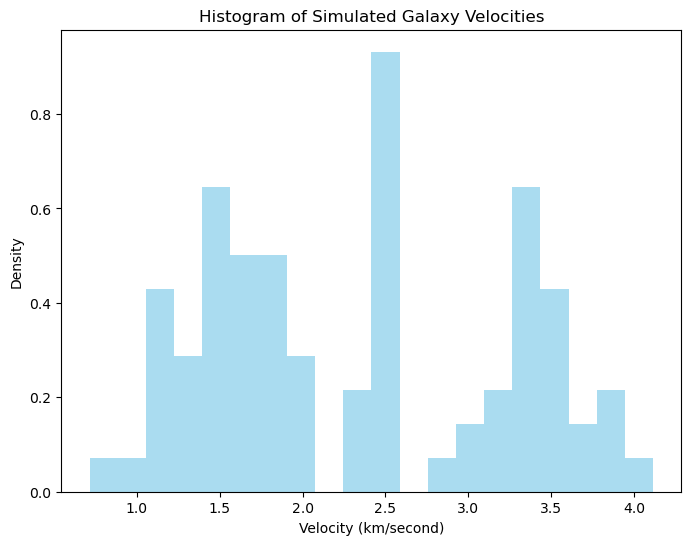

Iteration 0, Current k = 2
Iteration 100, Current k = 3
Iteration 200, Current k = 2
Iteration 300, Current k = 2
Iteration 400, Current k = 3
Iteration 500, Current k = 3
Iteration 600, Current k = 2
Iteration 700, Current k = 1
Iteration 800, Current k = 1
Iteration 900, Current k = 2


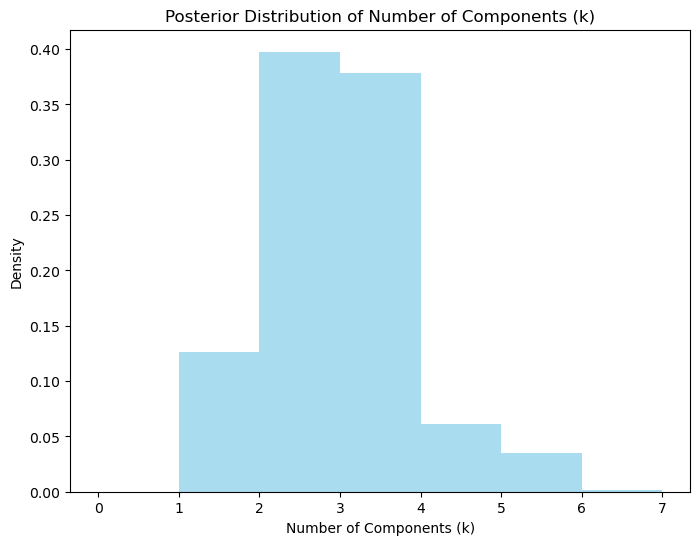

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

def propose_move(current_state: Dict, data: np.ndarray) -> Tuple[Dict, float]:
    """
    Propose a move in the reversible jump MCMC (birth, death, or update).
    Returns the proposed state and the Jacobian determinant for dimension changes.
    """
    k = current_state['k']
    weights = current_state['weights']
    means = current_state['means']
    stds = current_state['stds']
    
    move_type = np.random.choice(['birth', 'death', 'update'], p=[0.3, 0.3, 0.4])
    
    if move_type == 'birth' and k < 10:  # Max k for practicality
        new_k = k + 1
        new_weights = np.zeros(new_k)
        new_weights[:k] = weights * (1 - 0.5)  # Split weight for new component
        new_weights[k] = 0.5  # New component weight
        new_weights /= new_weights.sum()  # Normalize
        
        new_means = np.zeros(new_k)
        new_means[:k] = means
        new_means[k] = np.random.normal(np.mean(data), 1.0)  # Random mean
        
        new_stds = np.zeros(new_k)
        new_stds[:k] = stds
        new_stds[k] = np.random.uniform(0.1, 0.5)  # Random std
        
        jacobian = 1.0  # Simplified Jacobian (could be more complex)
        return {'k': new_k, 'weights': new_weights, 'means': new_means, 'stds': new_stds}, jacobian
    
    elif move_type == 'death' and k > 1:
        component_to_remove = np.random.randint(k)
        new_k = k - 1
        new_weights = np.delete(weights, component_to_remove)
        new_weights /= new_weights.sum()  # Normalize
        new_means = np.delete(means, component_to_remove)
        new_stds = np.delete(stds, component_to_remove)
        
        jacobian = 1.0  # Simplified Jacobian
        return {'k': new_k, 'weights': new_weights, 'means': new_means, 'stds': new_stds}, jacobian
    
    else:  # Update parameters
        if k > 0:
            component = np.random.randint(k)
            if np.random.random() < 0.5:
                means[component] += np.random.normal(0, 0.1)
            else:
                stds[component] = abs(stds[component] + np.random.normal(0, 0.05))
            weights = np.random.dirichlet(np.ones(k))  # Update weights
        
        jacobian = 1.0
        return {'k': k, 'weights': weights, 'means': means, 'stds': stds}, jacobian

def log_likelihood(data: np.ndarray, weights: np.ndarray, means: np.ndarray, stds: np.ndarray) -> float:
    """
    Compute the log-likelihood of the data under the mixture model.
    """
    ll = 0
    for x in data:
        comp_ll = np.log(np.sum(weights * stats.norm.pdf(x, means, stds)))
        ll += comp_ll
    return ll

def log_prior(k: int, weights: np.ndarray, means: np.ndarray, stds: np.ndarray) -> float:
    """
    Compute the log-prior for the model parameters.
    """
    # Uniform prior on k (e.g., k in [1, 10])
    log_k_prior = -np.log(10) if 1 <= k <= 10 else -np.inf
    
    # Dirichlet prior for weights (uniform)
    log_weights_prior = stats.dirichlet.logpdf(weights, np.ones(len(weights)))
    
    # Normal prior for means (centered at 0, variance 10)
    log_means_prior = np.sum(stats.norm.logpdf(means, 0, 10))
    
    # Inverse-gamma prior for stds (shape=2, scale=1)
    log_stds_prior = np.sum(stats.invgamma.logpdf(stds, 2, scale=1))
    
    return log_k_prior + log_weights_prior + log_means_prior + log_stds_prior

def reversible_jump_mcmc(data: np.ndarray, n_iter: int) -> List[Dict]:
    """
    Run reversible jump MCMC to sample from the posterior.
    """
    # Initialize with k=2 components (arbitrary starting point)
    k = 2
    weights = np.random.dirichlet(np.ones(k))
    means = np.random.normal(np.mean(data), 1.0, k)
    stds = np.random.uniform(0.1, 0.5, k)
    
    current_state = {'k': k, 'weights': weights, 'means': means, 'stds': stds}
    chain = [current_state.copy()]
    
    for i in range(n_iter):
        proposed_state, jacobian = propose_move(current_state, data)
        
        # Log posterior for current and proposed states
        current_log_posterior = log_likelihood(data, current_state['weights'], current_state['means'], current_state['stds']) + \
                               log_prior(current_state['k'], current_state['weights'], current_state['means'], current_state['stds'])
        
        proposed_log_posterior = log_likelihood(data, proposed_state['weights'], proposed_state['means'], proposed_state['stds']) + \
                                log_prior(proposed_state['k'], proposed_state['weights'], proposed_state['means'], proposed_state['stds'])
        
        # Acceptance probability (including Jacobian for dimension changes)
        log_acceptance = proposed_log_posterior - current_log_posterior + np.log(jacobian)
        
        if np.log(np.random.random()) < log_acceptance:
            current_state = proposed_state.copy()
        
        chain.append(current_state.copy())
        if i % 100 == 0:
            print(f"Iteration {i}, Current k = {current_state['k']}")
    
    return chain

# Set random seed for reproducibility
np.random.seed(42)

# True parameters for the mixture model (k=3 components)
n_components = 3
n_samples = 82  # Number of galaxies, as in the example
mix_weights = np.array([0.4, 0.3, 0.3])  # Mixing proportions
means = np.array([1.5, 2.5, 3.5])  # Means of Gaussian components
stds = np.array([0.3, 0.2, 0.25])  # Standard deviations

# Generate data
component = np.random.choice(n_components, size=n_samples, p=mix_weights)
data = np.array([np.random.normal(means[i], stds[i]) for i in component])

# Visualize the data
plt.figure(figsize=(8, 6))
plt.hist(data, bins=20, density=True, alpha=0.7, color='skyblue')
plt.title("Histogram of Simulated Galaxy Velocities")
plt.xlabel("Velocity (km/second)")
plt.ylabel("Density")
plt.show()

# Run the MCMC
n_iterations = 1000
chain = reversible_jump_mcmc(data, n_iterations)

# Analyze results
k_values = [state['k'] for state in chain]
plt.figure(figsize=(8, 6))
plt.hist(k_values, bins=range(max(k_values)+2), density=True, alpha=0.7, color='skyblue')
plt.title("Posterior Distribution of Number of Components (k)")
plt.xlabel("Number of Components (k)")
plt.ylabel("Density")
plt.show()

In [ ]:
import random
import math
from typing import List, Tuple, Dict

# Basic statistical functions without libraries
def normal_pdf(x: float, mean: float, std: float) -> float:
    """
    Compute the probability density function of a normal distribution.
    """
    variance = std * std
    exponent = -((x - mean) ** 2) / (2 * variance)
    return (1 / (std * math.sqrt(2 * math.pi))) * math.exp(exponent)

def dirichlet_pdf(weights: List[float], alpha: List[float]) -> float:
    """
    Compute the probability density function of a Dirichlet distribution (simplified, uniform case).
    Here, we use a uniform Dirichlet with alpha = [1, ..., 1].
    """
    if len(weights) != len(alpha):
        return 0.0
    product = 1.0
    for w in weights:
        if w <= 0 or w >= 1:
            return 0.0
        product *= w ** (alpha[0] - 1)
    return product / math.gamma(len(weights))  # Simplified for alpha=1

def invgamma_pdf(x: float, shape: float, scale: float) -> float:
    """
    Compute the probability density function of an inverse-gamma distribution.
    """
    if x <= 0:
        return 0.0
    return (scale ** shape) / (math.gamma(shape) * (x ** (shape + 1))) * math.exp(-scale / x)

def propose_move(current_state: Dict, data: List[float]) -> Tuple[Dict, float]:
    """
    Propose a move in the reversible jump MCMC (birth, death, or update).
    Returns the proposed state and the Jacobian determinant for dimension changes.
    """
    k = current_state['k']
    weights = current_state['weights']
    means = current_state['means']
    stds = current_state['stds']
    
    move_type = random.choices(['birth', 'death', 'update'], weights=[0.3, 0.3, 0.4])[0]
    
    if move_type == 'birth' and k < 10:  # Max k for practicality
        new_k = k + 1
        new_weights = [0.0] * new_k
        for i in range(k):
            new_weights[i] = weights[i] * 0.5  # Split weight for new component
        new_weights[k] = 0.5  # New component weight
        total = sum(new_weights)
        for i in range(new_k):
            new_weights[i] /= total  # Normalize
        
        new_means = [0.0] * new_k
        for i in range(k):
            new_means[i] = means[i]
        new_means[k] = random.gauss(sum(data) / len(data), 1.0)  # Random mean
        
        new_stds = [0.0] * new_k
        for i in range(k):
            new_stds[i] = stds[i]
        new_stds[k] = random.uniform(0.1, 0.5)  # Random std
        
        jacobian = 1.0  # Simplified Jacobian (could be more complex)
        return {'k': new_k, 'weights': new_weights, 'means': new_means, 'stds': new_stds}, jacobian
    
    elif move_type == 'death' and k > 1:
        component_to_remove = random.randint(0, k - 1)
        new_k = k - 1
        new_weights = [w for i, w in enumerate(weights) if i != component_to_remove]
        total = sum(new_weights)
        for i in range(len(new_weights)):
            new_weights[i] /= total  # Normalize
        new_means = [m for i, m in enumerate(means) if i != component_to_remove]
        new_stds = [s for i, s in enumerate(stds) if i != component_to_remove]
        
        jacobian = 1.0  # Simplified Jacobian
        return {'k': new_k, 'weights': new_weights, 'means': new_means, 'stds': new_stds}, jacobian
    
    else:  # Update parameters
        if k > 0:
            component = random.randint(0, k - 1)
            if random.random() < 0.5:
                means[component] += random.gauss(0, 0.1)
            else:
                stds[component] = abs(stds[component] + random.gauss(0, 0.05))
            # Update weights using Dirichlet (uniform prior)
            alpha = [1.0] * k
            weights = []
            for _ in range(k):
                w = random.random()
                weights.append(w)
            total = sum(weights)
            for i in range(len(weights)):
                weights[i] /= total  # Normalize to ensure sum to 1
        
        jacobian = 1.0
        return {'k': k, 'weights': weights, 'means': means, 'stds': stds}, jacobian

def log_likelihood(data: List[float], weights: List[float], means: List[float], stds: List[float]) -> float:
    """
    Compute the log-likelihood of the data under the mixture model.
    """
    ll = 0.0
    for x in data:
        comp_ll = 0.0
        for w, mu, sigma in zip(weights, means, stds):
            comp_ll += w * normal_pdf(x, mu, sigma)
        ll += math.log(comp_ll) if comp_ll > 0 else float('-inf')
    return ll

def log_prior(k: int, weights: List[float], means: List[float], stds: List[float]) -> float:
    """
    Compute the log-prior for the model parameters.
    """
    # Uniform prior on k (e.g., k in [1, 10])
    log_k_prior = -math.log(10) if 1 <= k <= 10 else float('-inf')
    
    # Dirichlet prior for weights (uniform, alpha=1 for each)
    alpha = [1.0] * len(weights)
    log_weights_prior = math.log(dirichlet_pdf(weights, alpha))
    
    # Normal prior for means (centered at 0, variance 10)
    log_means_prior = 0.0
    for mu in means:
        exponent = -((mu - 0) ** 2) / (2 * 10)
        log_means_prior += math.log((1 / (math.sqrt(2 * math.pi * 10))) * math.exp(exponent))
    
    # Inverse-gamma prior for stds (shape=2, scale=1)
    log_stds_prior = 0.0
    for sigma in stds:
        log_stds_prior += math.log(invgamma_pdf(sigma, 2.0, 1.0))
    
    return log_k_prior + log_weights_prior + log_means_prior + log_stds_prior

def reversible_jump_mcmc(data: List[float], n_iter: int) -> List[Dict]:
    """
    Run reversible jump MCMC to sample from the posterior.
    """
    # Initialize with k=2 components (arbitrary starting point)
    k = 2
    weights = []
    for _ in range(k):
        w = random.random()
        weights.append(w)
    total = sum(weights)
    for i in range(len(weights)):
        weights[i] /= total  # Normalize to ensure sum to 1
    means = [random.gauss(sum(data) / len(data), 1.0) for _ in range(k)]
    stds = [random.uniform(0.1, 0.5) for _ in range(k)]
    
    current_state = {'k': k, 'weights': weights, 'means': means, 'stds': stds}
    chain = [current_state.copy()]
    
    for i in range(n_iter):
        proposed_state, jacobian = propose_move(current_state, data)
        
        # Log posterior for current and proposed states
        current_log_posterior = log_likelihood(data, current_state['weights'], current_state['means'], current_state['stds']) + \
                               log_prior(current_state['k'], current_state['weights'], current_state['means'], current_state['stds'])
        
        proposed_log_posterior = log_likelihood(data, proposed_state['weights'], proposed_state['means'], proposed_state['stds']) + \
                                log_prior(proposed_state['k'], proposed_state['weights'], proposed_state['means'], proposed_state['stds'])
        
        # Acceptance probability (including Jacobian for dimension changes)
        log_acceptance = proposed_log_posterior - current_log_posterior + math.log(jacobian)
        
        if math.log(random.random()) < log_acceptance:
            current_state = proposed_state.copy()
        
        chain.append(current_state.copy())
        if i % 100 == 0:
            print(f"Iteration {i}, Current k = {current_state['k']}")
    
    return chain

# Set random seed for reproducibility
random.seed(42)

# True parameters for the mixture model (k=3 components)
n_components = 3
n_samples = 82  # Number of galaxies, as in the example
mix_weights = [0.4, 0.3, 0.3]  # Mixing proportions
means = [1.5, 2.5, 3.5]  # Means of Gaussian components
stds = [0.3, 0.2, 0.25]  # Standard deviations

# Generate data
data = []
for _ in range(n_samples):
    component = random.choices(range(n_components), weights=mix_weights)[0]
    x = random.gauss(means[component], stds[component])
    data.append(x)

# Simple text-based histogram for visualization (no matplotlib)
def print_histogram(data: List[float], bins: int = 20):
    """
    Print a text-based histogram of the data.
    """
    min_val, max_val = min(data), max(data)
    bin_size = (max_val - min_val) / bins
    counts = [0] * bins
    
    for x in data:
        bin_idx = min(int((x - min_val) / bin_size), bins - 1)
        counts[bin_idx] += 1
    
    total = sum(counts)
    for i, count in enumerate(counts):
        lower = min_val + i * bin_size
        upper = min_val + (i + 1) * bin_size
        density = count / (total * bin_size) if total > 0 else 0
        stars = int(density * 50)  # Scale for text visualization
        print(f"{lower:.2f}-{upper:.2f}: {'*' * stars} ({density:.3f})")

print("Histogram of Simulated Galaxy Velocities:")
print_histogram(data)

# Run the MCMC
n_iterations = 1000
chain = reversible_jump_mcmc(data, n_iterations)

# Analyze results (text-based histogram for k values)
k_values = [state['k'] for state in chain]
k_counts = {}
for k in k_values:
    k_counts[k] = k_counts.get(k, 0) + 1
total = sum(k_counts.values())

print("\nPosterior Distribution of Number of Components (k):")
for k in sorted(k_counts.keys()):
    density = k_counts[k] / total
    stars = int(density * 50)  # Scale for text visualization
    print(f"k={k}: {'*' * stars} (Probability: {density:.3f})")

## Difficulties in Model Choice

There are several kinds of difficulties with a formal resolution of the model choice issue. While the definition of a prior distribution on the parameter space

$$
\theta = \bigcup_{k} \{k\} \times \Theta_k
$$

does not create any problem, thanks to the decomposition of $\pi(k)$ into $\pi(k \mid \theta_k)$, a first difficulty is that at the inferential level model choice is a complex notion. The setting does not clearly belong either to the estimation or the testing domain.

As an example, when considering model choice as an estimation problem, there is a tendency to overfit the data by selecting a model $M_k$ with a large number of parameters, and overfitting can only be countered with priors distributions $\pi(\theta_k)$ that depend on the sample size (see Robert, 2001, Chapter 7). Similarly, when adopting the perspective that model choice is a special case of testing between models, the subsequent inference on the model’s “likelihood” model fails to account for the selection process and its inherent error. This vagueness, central to the model choice formulation, will translate into a requirement for a many-faceted prior distribution.

We trust stress here that our understanding of the Bayesian model choice issue is that we must choose a completely new set of parameters $\Theta_k$, and set the parameter space as the union of the model parameter spaces $\Theta_k$, even though some parameter spaces may have a similar meaning in two different models.

### Example 3: Order of an AR(p) model

Recall that an AR(p) model is given as the autoregressive representation of a time series,

$$
M_p : x_t = \sum_{i=1}^p \theta_i x_{t-i} + \sigma_p \epsilon_t,
$$

where the autoregressive coefficients $\theta_i$ (for $i=1,\dots,p$) would be the same as the $\theta_{p+1,i}$’s, that is, that an AR(p) model is simply an AR(p+1) model with an extra zero coefficient.

When comparing an AR(p) and an AR(p+1) model, it could be assumed that the autoregressive coefficients $\theta_i$ (for $i=1,\dots,p$) would be the same as the $\theta_{p+1,i}$’s, that is, that an AR(p) model is simply an AR(p+1) model with an extra zero coefficient.

We note that it is important to consider the coefficients for each of the models as an entire set of coefficients, and not individually. This is not only because the models are different, but, more importantly, because the best fitting AR(p+1) model is not necessarily a modification of the best fitting AR(p) model obtained by adding an extra term, that is, a non-zero $\theta_{p+1}$. Moreover, from a Bayesian point of view, the parameters $\theta_k$’s are not independent a posteriori. Similarly, even though the variance $\sigma_p^2$ has the same formal meaning for all values of $p$, we insist on using a different variance parameter for each value of $p$, hence the notation $\sigma_p^2$.

However, many statisticians prefer to use some parameters that are common to all models, in order to reduce model and computational complexity (Problems 11.1 and 11.2), and also to enforce Occam’s parsimony requirement (see Note 11.5.1). As we will see below, the reversible jump technique of Section 11.2 is based upon this assumption of partially exchangeable parameters between models, since it uses proposal distributions that modify only a part of the parameter vector to move between models. (The centering technique of Brooks et al. 2003b relates to the same assumption.)

Section 11.2 is the cornerstone of this book, there are also computational difficulties related to variable dimension models. For instance, the number of models in competition may well be infinite. Even when the number of models is finite, there is additional complexity in representing, or simulating from, the posterior distribution (11.2) in that a sampler must move both within and between models $\Theta_k$. While the former (move) pertains to previous developments in Chapters 7–10, the latter (move) requires a deeper measure-theoretic basis to ensure the overall validity of the correct MCMC moves, that is, to preserve $\pi(x)$ as the stationary distribution of the simulated Markov chain on $\Theta$.

Lastly, we mention that there is an enormous, and growing, literature on the topic of model selection, from both a frequentist and a Bayesian point of view. Starting with the seminal paper of Akaike (1974), which defined one of the first model selection criteria (now known as AIC), a major focus of that methodology is to examine the properties of the model selection procedure, and its inference, in some sense, that the correct model will be selected if the number of observations is infinite. (This is known as consistency in model selection.) However, many of our concerns are different from those in the model selection literature, and we will not go into details of the many model selection criteria that are available. A good introduction to the many facets of model selection is edited by Lahiri (2001).

In [3]:
import random
import math
from typing import List, Dict

# Basic statistical functions without libraries
def normal_pdf(x: float, mean: float, std: float) -> float:
    """
    Compute the probability density function of a normal distribution.
    """
    variance = std * std
    exponent = -((x - mean) ** 2) / (2 * variance)
    return (1 / (std * math.sqrt(2 * math.pi))) * math.exp(exponent)

def ar_likelihood(data: List[float], p: int, theta: List[float], sigma: float) -> float:
    """
    Compute the log-likelihood of the data under an AR(p) model.
    """
    n = len(data)
    ll = 0.0
    for t in range(p, n):
        pred = sum(theta[i] * data[t - i - 1] for i in range(p))
        error = data[t] - pred
        ll += -0.5 * math.log(2 * math.pi * sigma * sigma) - (error * error) / (2 * sigma * sigma)
    return ll

def log_prior_model(p: int) -> float:
    """
    Uniform prior over model orders (e.g., p=1 or p=2).
    """
    return -math.log(2)  # Uniform prior over {1, 2}

def log_prior_params(theta: List[float], sigma: float) -> float:
    """
    Normal prior for theta (mean=0, variance=10) and inverse-gamma for sigma (shape=2, scale=1).
    """
    log_theta_prior = 0.0
    for t in theta:
        exponent = -((t - 0) ** 2) / (2 * 10)
        log_theta_prior += math.log((1 / (math.sqrt(2 * math.pi * 10))) * math.exp(exponent))
    
    log_sigma_prior = math.log((1 ** 2) / (math.gamma(2) * (sigma ** (2 + 1))) * math.exp(-1 / sigma))
    return log_theta_prior + log_sigma_prior

def mcmc_model_choice(data: List[float], n_iter: int) -> List[int]:
    """
    Run MCMC to sample model orders (p=1 or p=2).
    """
    # Initialize with p=1
    current_p = 1
    if current_p == 1:
        theta = [random.gauss(0, math.sqrt(10))]  # AR(1) coefficient
        sigma = random.uniform(0.1, 2.0)  # Noise std
    else:  # p=2
        theta = [random.gauss(0, math.sqrt(10)), random.gauss(0, math.sqrt(10))]  # AR(2) coefficients
        sigma = random.uniform(0.1, 2.0)  # Noise std
    
    chain = [current_p]
    
    for i in range(n_iter):
        # Propose a new model order (toggle between p=1 and p=2)
        proposed_p = 2 if current_p == 1 else 1
        
        # Propose new parameters for the proposed model
        if proposed_p == 1:
            new_theta = [random.gauss(0, math.sqrt(10))]
            new_sigma = random.uniform(0.1, 2.0)
        else:  # proposed_p == 2
            new_theta = [random.gauss(0, math.sqrt(10)), random.gauss(0, math.sqrt(10))]
            new_sigma = random.uniform(0.1, 2.0)
        
        # Compute log posterior for current and proposed models
        current_log_posterior = ar_likelihood(data, current_p, theta, sigma) + \
                               log_prior_model(current_p) + log_prior_params(theta, sigma)
        
        proposed_log_posterior = ar_likelihood(data, proposed_p, new_theta, new_sigma) + \
                                log_prior_model(proposed_p) + log_prior_params(new_theta, new_sigma)
        
        # Acceptance probability
        log_acceptance = proposed_log_posterior - current_log_posterior
        
        if math.log(random.random()) < log_acceptance:
            current_p = proposed_p
            theta = new_theta
            sigma = new_sigma
        
        chain.append(current_p)
        if i % 100 == 0:
            print(f"Iteration {i}, Current p = {current_p}")
    
    return chain

def print_histogram(data: List[float], bins: int = 20):
    """
    Print a text-based histogram of the data.
    """
    min_val, max_val = min(data), max(data)
    bin_size = (max_val - min_val) / bins
    counts = [0] * bins
    
    for x in data:
        bin_idx = min(int((x - min_val) / bin_size), bins - 1)
        counts[bin_idx] += 1
    
    total = sum(counts)
    for i, count in enumerate(counts):
        lower = min_val + i * bin_size
        upper = min_val + (i + 1) * bin_size
        density = count / (total * bin_size) if total > 0 else 0
        stars = int(density * 50)  # Scale for text visualization
        print(f"{lower:.2f}-{upper:.2f}: {'*' * stars} ({density:.3f})")

# Set random seed for reproducibility
random.seed(42)

# Parameters for AR(2) model
p = 2
theta = [0.5, 0.3]  # AR coefficients
sigma = 1.0  # Standard deviation of noise
n_samples = 100  # Number of time points

# Generate AR(2) data
data = [0.0] * n_samples
for t in range(p, n_samples):
    noise = random.gauss(0, sigma)
    data[t] = sum(theta[i] * data[t - i - 1] for i in range(p)) + noise

# Print text-based histogram of the data
print("Histogram of Simulated AR(2) Time Series:")
print_histogram(data)

# Run the MCMC
n_iterations = 1000
chain = mcmc_model_choice(data, n_iterations)

# Analyze results (text-based histogram for p values)
p_values = chain
p_counts = {1: 0, 2: 0}
for p in p_values:
    p_counts[p] += 1
total = sum(p_counts.values())

print("\nPosterior Distribution of Model Order (p):")
for p in sorted(p_counts.keys()):
    density = p_counts[p] / total
    stars = int(density * 50)  # Scale for text visualization
    print(f"p={p}: {'*' * stars} (Probability: {density:.3f})")

Histogram of Simulated AR(2) Time Series:
-3.03--2.73: *** (0.067)
-2.73--2.44: * (0.034)
-2.44--2.14: * (0.034)
-2.14--1.84: ****** (0.134)
-1.84--1.54:  (0.000)
-1.54--1.24: ****** (0.134)
-1.24--0.95: ***** (0.101)
-0.95--0.65: ********** (0.201)
-0.65--0.35: ******** (0.168)
-0.35--0.05: ************************* (0.503)
-0.05-0.25: ************************** (0.537)
0.25-0.54: ************* (0.268)
0.54-0.84: ************* (0.268)
0.84-1.14: **************** (0.335)
1.14-1.44: *********** (0.235)
1.44-1.74: ***** (0.101)
1.74-2.03: * (0.034)
2.03-2.33: ****** (0.134)
2.33-2.63:  (0.000)
2.63-2.93: *** (0.067)
Iteration 0, Current p = 2
Iteration 100, Current p = 1
Iteration 200, Current p = 1
Iteration 300, Current p = 1
Iteration 400, Current p = 1
Iteration 500, Current p = 1
Iteration 600, Current p = 1
Iteration 700, Current p = 1
Iteration 800, Current p = 1
Iteration 900, Current p = 1

Posterior Distribution of Model Order (p):
p=1: *****************************************

# Reversible Jump Algorithms

There have been several earlier approaches in the literature to deal with variable dimension models using, for instance, birth-and-death processes (Ripley 1977, Geyer and Møller 1994) or pseudo-priors (Carlin and Chib 1995, see Problem 11.9), but the general formalization of this problem by Green (1995) is a landmark. Note that, at this stage, regular Gibbs sampling is impossible when considering distributions on the form (11.2) if one conditions on $k$, then $\theta_k \in \Theta_k$, and if one conditions on $\theta_k$, then $k$ cannot move. Therefore, a standard Gibbs sampler cannot provide moves between models $\Theta_k$ without further modification of the setting.

## 11.2.1 Green’s Algorithm

If we let $x = (k, \theta_k)$, the solution proposed by Green (1995) is based on a reversible transition kernel $K$, that is, a kernel satisfying

$$
\int_{A \times B} K(x, dy) \pi(x) dx = \int_{A \times B} K(y, dx) \pi(y) dy
$$

for all $A, B \subset \Theta$ and for some invariant density $\pi$ (see Section 6.5.3). To see more clearly how this condition can be satisfied and how a proper reversible kernel $K$ can be constructed, we decompose $K$ according to the model in which $x$ and $y$ can be found, i.e., according to the model $M_{k_x}$ and $M_{k_y}$ denoting a transition measure (or jump). The decomposition of the kernel is thus

$$
K(x, B) = \sum_{y \in B} \int_{M_{k_x} \times M_{k_y}} q(x, dy) + w(x) I_B(x),
$$

where

$$
w(x) = 1 - \sum_{m \neq k_x} q_m(x, \Theta_m)
$$

represents the probability of no move.

Typically, and mostly for practicality’s sake, the jumps are limited to moves from $M_{k_x}$ to models with dimensionalities close to the dimension of $\Theta_{k_x}$, possibly including $y = M_{k_x}$, constructing generally sensible proposal $q_m$. A move from $x = (m, \theta_m)$ to $y = (n, \theta_n)$ is generally too difficult when $M_n$ and $M_{k_x}$ differ by many dimensions. The definition of $q_m$ (and the verification of the reversibility assumptions) relies on the following assumption: The joint measure $\pi(x) dx, dy$ must be absolutely continuous with respect to a symmetric measure $\xi_n(x, dx, dy)$ on $\Theta \times \Theta$. If $\pi(x, y)$ denotes the density of $\pi(x)$ with respect to $\xi_n(x, dx, dy)$, and if $\pi_m$ is written in the usual Metropolis-Hastings form

$$
\rho_m(x, y) = \min \left\{ \frac{q_m(y, x)}{q_m(x, y)} \right\},
$$

then reversibility is ensured by the symmetry of the measure $\xi_n$:

$$
\int_{A \times B} \rho_m(x, y) q_m(x, dy) \pi(x) dx = \int_{A \times B} \rho_m(y, x) q_m(y, dx) \pi(y) dy
$$

$$
= \int_{A \times B} \rho_m(x, y) q_m(x, dy) \pi(x) dx = \int_{A \times B} \rho_m(y, x) q_m(y, dx) \pi(y) dy,
$$

as $\rho_m(x, y) = \rho_m(y, x)$ by construction.

The main difficulty of this approach lies in the determination of the measure $\xi_n$ given the symmetry constraint. If the jumps are decomposed into moves between pairs of models, $M_{k_x}$ and $M_{k_y}$, the (clever) idea of Green (1995) is slightly involved. For an alternate description of this technique, which might be easier to understand, we refer the reader to Section 11.2.2. There the reversible jump algorithm is justified using ordinary Metropolis-Hastings arguments.

Green (1995) imposes a dimension-matching condition which is that the opposite move from $\Theta_{k_y}$ to $\Theta_{k_x}$ is concentrated on the curve

$$
\{(\theta_{k_y}^{k_x}, \theta_{k_y}) = T(\theta_{k_x}^{k_y})\},
$$

into $[\theta_{k_x}, u_1]$ and $[\theta_{k_y}, v_2]$ by $u_1 = q(u_2)$ into $[\theta_{k_y}, v_2]$, so that the mapping between $[\theta_{k_x}, u_1]$ and $[\theta_{k_y}, v_2]$ is a bijection,

$$
(\theta_{k_x}, u_1) \text{ and } (\theta_{k_y}, v_2) = T(\theta_{k_x}^{k_y}, u_1),
$$

the probability of acceptance for the move from $M_{k_x}$ to $M_{k_y}$ is then

$$
\min \left\{ \frac{\pi(\theta_{k_y}, \theta_{k_y}^{k_x}) q_{k_y}(\theta_{k_y}, \theta_{k_y}^{k_x})}{ \pi(\theta_{k_x}, \theta_{k_x}^{k_y}) q_{k_x}(\theta_{k_x}, \theta_{k_x}^{k_y})}, 1 \right\},
$$

involving the Jacobian of the transformation (11.3), the probability $\pi_{k_y}$ of choosing a jump to $M_{k_y}$, while in $M_{k_y}$, and $q_{k_y}$, the density of this proposal saturates (Green, 1995) from the balance condition $M_{k_y}$ to $M_{k_x}$, and also satisfies (11.3) with $u_2 = q(u_1)$.

The pseudo-code representation of Green’s (1995) algorithm is thus as follows:

**Algorithm A.48 — Green’s Algorithm**

At iteration $t$, if $x^{(t)} = (m, \theta_m^{(t)})$,
1. Select model $M_n$, with probability $\pi_{nm}$.
2. Generate $u_{nm}$ with probability $q_{nm}(x^{(t)}, u_{nm})$.
3. Set $(\theta_n^{(t)}, v_{nm}) = T_{nm}(\theta_m^{(t)}, u_{nm})$.
4. Take $\theta_n^{(t+1)} = \theta_n^{(t)}$ with probability

$$
\min \left\{ \frac{\pi(\theta_n^{(t)}, v_{nm}) q_{mn}(v_{nm}, u_{nm})}{ \pi(\theta_m^{(t)}, u_{nm}) q_{nm}(\theta_m^{(t)}, u_{nm})}, 1 \right\},
$$

and take $\theta_m^{(t+1)} = \theta_m^{(t)}$ otherwise.

As pointed out by Green (1995), the density $\pi$ does not need to be normalized, but the different component densities $\pi_k(\theta_k)$ must be known up to the same constant.

# Example 11.4: A Linear Jacobian

To illustrate the procedure, Green (1995) considers the toy example of switching between the parameters $(1, \theta_2)$ and $(2, \theta_2)$, using the following moves:
1. To go from $(1, \theta_2)$ to $(2, \theta_2)$, set $\theta = (\theta_2 + \theta_3)/2$, generate a random variable $u \sim q(u)$ and set $\theta_2 = \theta - u$, $\theta_3 = \theta + u$.
2. To go from $(2, \theta_2)$ to $(1, \theta_2)$, generate a random variable $u \sim q(u)$ and set $\theta_1 = \theta - u$, $\theta_2 = \theta + u$.

These moves represent one-to-one transformations of variables in $\mathbb{R}^2$, that is,

$$
(\theta_1, \theta_2, \theta_3) = T_{21}(\theta_2, \theta_3), \quad (\theta - u, \theta + u) = T_{12}(\theta, u),
$$

with corresponding Jacobians

$$
\frac{\partial T_{21}(\theta_2, \theta_3)}{\partial (\theta_2, \theta_3)} = 2, \quad \frac{\partial T_{12}(\theta, u)}{\partial (\theta, u)} = 2.
$$

The acceptance probability for a move from $(1, \theta_2)$ to $(2, \theta_2)$ is thus

$$
\min \left( \frac{\pi(2, \theta_2, u)}{ \pi(1, \theta_2) q(u)}, 1 \right),
$$

where $u = (\theta_2 - \theta_3)/2$.



In [4]:
import random
import math
from typing import List, Tuple, Dict

# Basic statistical functions without libraries
def normal_pdf(x: float, mean: float, std: float) -> float:
    """
    Compute the probability density function of a normal distribution.
    """
    variance = std * std
    exponent = -((x - mean) ** 2) / (2 * variance)
    return (1 / (std * math.sqrt(2 * math.pi))) * math.exp(exponent)

def log_prior_model(k: int, theta: List[float]) -> float:
    """
    Uniform prior over models (k=1 or k=2) and normal prior for theta (mean=0, variance=10).
    """
    log_k_prior = -math.log(2)  # Uniform prior over {1, 2}
    log_theta_prior = 0.0
    for t in theta:
        exponent = -((t - 0) ** 2) / (2 * 10)
        log_theta_prior += math.log((1 / (math.sqrt(2 * math.pi * 10))) * math.exp(exponent))
    return log_k_prior + log_theta_prior

def log_likelihood(k: int, theta: List[float], data: List[float]) -> float:
    """
    Compute the log-likelihood for models (k=1 or k=2) with simulated data (assumed normal).
    For simplicity, assume data points are drawn from N(theta[0], 1) for k=1, and N(theta[0], 1) + N(theta[1], 1) for k=2.
    """
    ll = 0.0
    n = len(data)
    if k == 1:
        for x in data:
            ll += math.log(normal_pdf(x, theta[0], 1.0))
    else:  # k == 2
        for x in data:
            ll += math.log(0.5 * normal_pdf(x, theta[0], 1.0) + 0.5 * normal_pdf(x, theta[1], 1.0))
    return ll

def propose_move(current_state: Dict) -> Tuple[Dict, float]:
    """
    Propose a move in Green’s reversible jump MCMC between (1, θ_2) and (2, θ_2).
    Returns the proposed state and the Jacobian determinant for dimension changes.
    """
    k = current_state['k']
    theta = current_state['theta']
    
    if k == 1:  # Move from (1, θ_2) to (2, θ_2)
        theta_2 = theta[0]
        u = random.gauss(0, 1.0)  # Random variable u ~ N(0, 1)
        theta_new = [theta_2 - u, theta_2 + u]  # θ_2 = θ - u, θ_3 = θ + u
        new_k = 2
        jacobian = 2.0  # Jacobian from Example 11.4
        return {'k': new_k, 'theta': theta_new}, jacobian
    
    else:  # Move from (2, θ_2) to (1, θ_2)
        theta_2 = (theta[0] + theta[1]) / 2  # θ = (θ_2 + θ_3)/2
        u = (theta[0] - theta[1]) / 2  # u = (θ_2 - θ_3)/2 for reference
        new_k = 1
        jacobian = 2.0  # Jacobian from Example 11.4
        return {'k': new_k, 'theta': [theta_2]}, jacobian

def reversible_jump_mcmc(data: List[float], n_iter: int) -> List[Dict]:
    """
    Run Green’s reversible jump MCMC to sample from the posterior of models (k=1 or k=2).
    """
    # Initialize with k=1, θ_2 = 0
    k = 1
    theta = [random.gauss(0, math.sqrt(10))]  # θ_2 ~ N(0, 10)
    
    current_state = {'k': k, 'theta': theta}
    chain = [current_state.copy()]
    
    for i in range(n_iter):
        proposed_state, jacobian = propose_move(current_state)
        
        # Log posterior for current and proposed states
        current_log_posterior = log_likelihood(current_state['k'], current_state['theta'], data) + \
                               log_prior_model(current_state['k'], current_state['theta'])
        
        proposed_log_posterior = log_likelihood(proposed_state['k'], proposed_state['theta'], data) + \
                                log_prior_model(proposed_state['k'], proposed_state['theta'])
        
        # Acceptance probability (including Jacobian for dimension changes)
        log_acceptance = proposed_log_posterior - current_log_posterior + math.log(jacobian)
        
        if math.log(random.random()) < log_acceptance:
            current_state = proposed_state.copy()
        
        chain.append(current_state.copy())
        if i % 100 == 0:
            print(f"Iteration {i}, Current k = {current_state['k']}")
    
    return chain

def print_histogram(data: List[int], bins: int = 2):
    """
    Print a text-based histogram of the data (for k values: 1 or 2).
    """
    min_val, max_val = min(data), max(data)
    bin_size = (max_val - min_val) / bins
    counts = [0] * bins
    
    for x in data:
        bin_idx = min(int((x - min_val) / bin_size), bins - 1)
        counts[bin_idx] += 1
    
    total = sum(counts)
    for i, count in enumerate(counts):
        lower = min_val + i * bin_size
        upper = min_val + (i + 1) * bin_size
        density = count / total if total > 0 else 0
        stars = int(density * 50)  # Scale for text visualization
        print(f"{lower:.0f}-{upper:.0f}: {'*' * stars} (Probability: {density:.3f})")

# Set random seed for reproducibility
random.seed(42)

# Generate synthetic data (assume 50 points from N(0, 1) for simplicity)
n_samples = 50
data = [random.gauss(0, 1.0) for _ in range(n_samples)]

# Run the MCMC
n_iterations = 1000
chain = reversible_jump_mcmc(data, n_iterations)

# Analyze results (text-based histogram for k values)
k_values = [state['k'] for state in chain]
print("\nPosterior Distribution of Model Order (k):")
print_histogram(k_values)

Iteration 0, Current k = 2
Iteration 100, Current k = 2
Iteration 200, Current k = 2
Iteration 300, Current k = 2
Iteration 400, Current k = 2
Iteration 500, Current k = 2
Iteration 600, Current k = 2
Iteration 700, Current k = 2
Iteration 800, Current k = 2
Iteration 900, Current k = 2

Posterior Distribution of Model Order (k):
1-2:  (Probability: 0.005)
2-2: ************************************************* (Probability: 0.995)


## A Fixed Dimension Reassessment

While the above development is completely valid from a mathematical point of view, we now redefine Green’s algorithm via a saturation scheme that provides better intuition for the determination of the acceptance probability. When considering a specific move from $M_m$ to $M_n$, that is, from $\theta_m \in \Theta_m$ to $\theta_n \in \Theta_n$, we indeed have $d_m = \dim \Theta_m < d_n = \dim \Theta_n$, we can indeed describe an auxiliary variable $u \in \mathbb{R}^{d_n - d_m}$, so that $\theta_n = T_m(\theta_m, u)$, and $\theta_m$ are in bijection (one-to-one).

As described above, the central feature of Green’s algorithm is to add an auxiliary variable $u \in \mathbb{R}^{d_n - d_m}$ so that $\theta_n = T_{mn}(\theta_m, u)$, and we consider that the special case, where $\theta_m$ are not completed (using a regular Metropolis-Hastings scheme, to propose a move from the pair $(\theta_m, u_m)$ to $\theta_n$ is like proposing to do so when the corresponding stationary distributions are $\pi(m, \theta_m) q_{mn}(\theta_m, u_{mn})$ and $\pi(n, \theta_n)$, respectively, and when the proposal distribution is deterministic, since $\theta_n = T_{mn}(\theta_m, u_{mn})$).

This unusual setting for Metropolis-Hastings moves, because of its deterministic nature, but it can be solved by the following approximation: Consider the move from $(\theta_m, u_{mn})$ to $\theta_n$ proceeds by generating

$$
\theta_n = N_{d_n}(T_{mn}(\theta_m, u_{mn}), \epsilon I),
$$

and that the reciprocal proposal then has the density

$$
\exp \left\{ -\frac{1}{2} (2\pi)^{d_n/2} \left[ \frac{\|T_{mn}(\theta_m, u_{mn}) - \theta_n\|^2}{\epsilon^2} \right] \right\} \times \left| \frac{\partial T_{mn}(\theta_m, u_{mn})}{\partial (\theta_m, u_{mn})} \right|.
$$

by the Jacobian rule. Therefore, the Metropolis-Hastings acceptance ratio for this Jacobian move is:

$$
1 \wedge \left( \frac{\pi(n, \theta_n) q_{mn}(\theta_m, u_{mn})}{ \pi(m, \theta_m) q_{nm}(\theta_n, u_{nm})} \right)
\times
\exp \left\{ -\frac{1}{2} (2\pi)^{d_n/2} \left[ \frac{\|T_{mn}(\theta_m, u_{mn}) - \theta_n\|^2}{\epsilon^2} \right] \right\}
\times
\exp \left\{ -\frac{1}{2} (2\pi)^{d_n/2} \left[ \frac{\|T_{nm}(\theta_n, u_{nm}) - \theta_m\|^2}{\epsilon^2} \right] \right\},
$$

and the normal densities cancel in a regular random walk proposal. If we take into account the probabilities of the moves between $M_m$ and $M_n$, we end up with

$$
1 \wedge \left( \frac{\pi(n, \theta_n) q_{mn}(\theta_m, u_{mn})}{ \pi(m, \theta_m) q_{nm}(\theta_n, u_{nm})} \right).
$$

Since this probability does not depend on $\epsilon$, we can let $\epsilon \to 0$ and obtain the equivalent of the ratio (11.4). The reversible jump algorithm can thus be the reinterpretation of local fixed dimensional moves between the models $M_k$ (Problem 11.5).

## The Practice of Reversible Jump MCMC

The dimension matching transform, $T_{mn}$, while incredibly flexible, can be quite difficult to create and much more difficult to optimize; one could almost say this difficulty, in the choice of $T_{mn}$, is a drawback with the method. In fact, the total freedom left by the reversible jump principle about the choice of the jumps, which are often referred to as split and merge moves in embedded models, creates a potential opening for inefficiency and requires tuning steps which can be quite demanding. As also mentioned in a later chapter, this is a setting where wealth is a mixed blessing, if only because the total lack of calibration of the algorithm.

### Example 5: Linear versus Quadratic Regression

Consider a particular regression. Instead of choosing a model averaging, we can use the reversible jump algorithm to do model averaging.

Suppose that the two candidate models are the linear and quadratic regression models:

$$
y_i = \beta_0 + \beta_1 x_i + \epsilon_i, \quad \text{and} \quad y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \epsilon_i,
$$

If we represent either regression by $y = X \beta + \epsilon$, where $\epsilon \sim \mathcal{N}(0, \sigma^2 I)$, the least squares estimate $\hat{\beta} = (X^T X)^{-1} X^T y$ has distribution

$$
\hat{\beta} \sim \mathcal{N}(\beta, \sigma^2 (X^T X)^{-1}).
$$

Using normal prior distributions will result in normal posterior distributions, and the reversible jump algorithm will then be jumping between a two-dimensional and three-dimensional normal distribution.

To jump between these models, it seems sensible to first transform orthogonal coordinates, as a jump that is made by simply adding or deleting a coefficient will not affect the fit of the other coefficients. We thus find an orthogonal matrix $P$ and diagonal matrix $D_A$ satisfying

$$
P^T X^T X P = D_A.
$$

The elements of $D_A, \lambda_i$, are the eigenvalues of $X^T X$ and the columns of $P$ are its eigenvectors. We then write $X' = X P$ and $a = P^T \beta$, and we work with the model $y = X' a + \epsilon$.

If each $a_i$ has a normal prior distribution, $a_i \sim \mathcal{N}(0, \tau^2)$, its posterior density, denoted $f_i(s \mid a_i, b_i, \sigma^2)$, where $a_i = \lambda_i^{-1/2} \tau^2$, its possible moves are:
1. (linear — linear): $(\alpha_0, \alpha_1) \to (\alpha_0', \alpha_1')$, where $(\alpha_0', \alpha_1') \sim f_{01}$.
2. (linear — quadratic): $(\alpha_0, \alpha_1) \to (\alpha_0', \alpha_1', \alpha_2')$, where $(\alpha_0', \alpha_1', \alpha_2') \sim f_{012}$.
3. (quadratic — quadratic): $(\alpha_0, \alpha_1, \alpha_2) \to (\alpha_0', \alpha_1', \alpha_2')$, where $(\alpha_0', \alpha_1', \alpha_2') \sim f_{012}$.
4. (quadratic — linear): $(\alpha_0, \alpha_1, \alpha_2) \to (\alpha_0', \alpha_1')$, where $(\alpha_0', \alpha_1') \sim f_{01}$.

The algorithm was implemented on simulated data with move probabilities $\pi_{ij}$ all taken to be 1/4 and a prior probability of 1/2 on each regression model. The resulting fits are given in Figure 11.2. It is interesting to note that when the model is quadratic, the reversible jump fit is close to that of quadratic least squares, but it deviates from quadratic least squares when the underlying model is linear. (See Problem 11.3 for more details.)

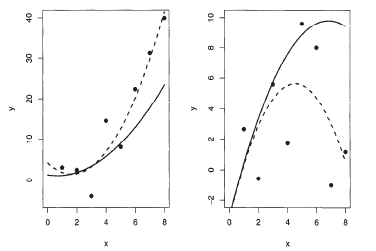




### Example 6: Piecewise Constant Densities

Consider a density $f(x)$ on $[0, 1]$ of the form

$$
f(x) = \sum_{i=1}^k w_i f_{a_i, b_i}(x),
$$

where the $w_i$ are weights summing to 1, and $f_{a_i, b_i}(x)$ are piecewise constant functions.

In [5]:
import random
import math
from typing import List, Tuple, Dict

# Basic statistical functions without libraries
def normal_pdf(x: float, mean: float, std: float) -> float:
    """
    Compute the probability density function of a normal distribution.
    """
    variance = std * std
    exponent = -((x - mean) ** 2) / (2 * variance)
    return (1 / (std * math.sqrt(2 * math.pi))) * math.exp(exponent)

def log_likelihood(k: int, beta: List[float], x: List[float], y: List[float], sigma: float) -> float:
    """
    Compute the log-likelihood for linear (k=1) or quadratic (k=2) regression.
    """
    ll = 0.0
    for x_i, y_i in zip(x, y):
        if k == 1:  # Linear: y = β_0 + β_1 x
            pred = beta[0] + beta[1] * x_i
        else:  # k == 2, Quadratic: y = β_0 + β_1 x + β_2 x^2
            pred = beta[0] + beta[1] * x_i + beta[2] * x_i * x_i
        error = y_i - pred
        ll += -0.5 * math.log(2 * math.pi * sigma * sigma) - (error * error) / (2 * sigma * sigma)
    return ll

def log_prior_model(k: int, beta: List[float]) -> float:
    """
    Uniform prior over models (k=1 or k=2) and normal prior for beta (mean=0, variance=10).
    """
    log_k_prior = -math.log(2)  # Uniform prior over {1, 2}
    log_beta_prior = 0.0
    for b in beta:
        exponent = -((b - 0) ** 2) / (2 * 10)
        log_beta_prior += math.log((1 / (math.sqrt(2 * math.pi * 10))) * math.exp(exponent))
    return log_k_prior + log_beta_prior

def log_prior_sigma(sigma: float) -> float:
    """
    Inverse-gamma prior for sigma (shape=2, scale=1).
    """
    return math.log((1 ** 2) / (math.gamma(2) * (sigma ** (2 + 1))) * math.exp(-1 / sigma))

def propose_move(current_state: Dict, x: List[float]) -> Tuple[Dict, float]:
    """
    Propose a move in Green’s reversible jump MCMC between linear (k=1) and quadratic (k=2) models.
    Returns the proposed state and the Jacobian determinant for dimension changes.
    """
    k = current_state['k']
    beta = current_state['beta']
    sigma = current_state['sigma']
    
    if k == 1:  # Move from linear to quadratic (k=1 to k=2)
        beta_0, beta_1 = beta
        u = random.gauss(0, 0.1)  # Auxiliary variable for dimension matching
        beta_new = [beta_0, beta_1, u]  # Add β_2 = u
        new_k = 2
        jacobian = 1.0  # Simplified Jacobian (could be adjusted for specific transform)
        return {'k': new_k, 'beta': beta_new, 'sigma': sigma}, jacobian
    
    else:  # Move from quadratic to linear (k=2 to k=1)
        beta_0, beta_1, beta_2 = beta
        beta_new = [beta_0, beta_1]  # Drop β_2
        new_k = 1
        jacobian = 1.0  # Simplified Jacobian
        return {'k': new_k, 'beta': beta_new, 'sigma': sigma}, jacobian

def reversible_jump_mcmc(x: List[float], y: List[float], n_iter: int) -> List[Dict]:
    """
    Run Green’s reversible jump MCMC to sample from the posterior of linear vs. quadratic models.
    """
    # Initialize with linear model (k=1), random beta, and sigma
    k = 1
    beta = [random.gauss(0, math.sqrt(10)), random.gauss(0, math.sqrt(10))]  # [β_0, β_1]
    sigma = random.uniform(0.1, 1.0)  # Noise std
    
    current_state = {'k': k, 'beta': beta, 'sigma': sigma}
    chain = [current_state.copy()]
    
    for i in range(n_iter):
        proposed_state, jacobian = propose_move(current_state, x)
        
        # Log posterior for current and proposed states
        current_log_posterior = log_likelihood(current_state['k'], current_state['beta'], x, y, current_state['sigma']) + \
                               log_prior_model(current_state['k'], current_state['beta']) + \
                               log_prior_sigma(current_state['sigma'])
        
        proposed_log_posterior = log_likelihood(proposed_state['k'], proposed_state['beta'], x, y, proposed_state['sigma']) + \
                                log_prior_model(proposed_state['k'], proposed_state['beta']) + \
                                log_prior_sigma(proposed_state['sigma'])
        
        # Acceptance probability (including Jacobian for dimension changes)
        log_acceptance = proposed_log_posterior - current_log_posterior + math.log(jacobian)
        
        if math.log(random.random()) < log_acceptance:
            current_state = proposed_state.copy()
        
        chain.append(current_state.copy())
        if i % 100 == 0:
            print(f"Iteration {i}, Current k = {current_state['k']}")
    
    return chain

def piecewise_likelihood(k: int, weights: List[float], intervals: List[Tuple[float, float]], data: List[float]) -> float:
    """
    Compute the log-likelihood for piecewise constant densities with k intervals.
    Assume data points are uniform in [0, 1], and each interval has a constant density.
    """
    ll = 0.0
    total_weight = sum(weights)
    for x in data:
        for i in range(k):
            start, end = intervals[i]
            if start <= x < end:
                ll += math.log(weights[i] / (end - start) / total_weight)
                break
        else:
            ll += float('-inf')  # Point outside intervals (should not happen)
    return ll

def propose_piecewise_move(current_state: Dict) -> Tuple[Dict, float]:
    """
    Propose a move in reversible jump MCMC between k=1 and k=2 piecewise intervals.
    """
    k = current_state['k']
    weights = current_state['weights']
    intervals = current_state['intervals']
    
    if k == 1:  # Move from 1 interval to 2 intervals
        w = weights[0]
        start, end = intervals[0]
        mid = random.uniform(start, end)
        weights_new = [w * 0.5, w * 0.5]  # Split weight
        intervals_new = [(start, mid), (mid, end)]
        new_k = 2
        jacobian = 1.0  # Simplified Jacobian
        return {'k': new_k, 'weights': weights_new, 'intervals': intervals_new}, jacobian
    
    else:  # Move from 2 intervals to 1 interval
        w1, w2 = weights
        start1, end1 = intervals[0]
        start2, end2 = intervals[1]
        weights_new = [w1 + w2]  # Merge weights
        intervals_new = [(min(start1, start2), max(end1, end2))]
        new_k = 1
        jacobian = 1.0  # Simplified Jacobian
        return {'k': new_k, 'weights': weights_new, 'intervals': intervals_new}, jacobian

def reversible_jump_piecewise(data: List[float], n_iter: int) -> List[Dict]:
    """
    Run reversible jump MCMC for piecewise constant densities.
    """
    # Initialize with k=1 interval, uniform weight, and [0, 1]
    k = 1
    weights = [1.0]
    intervals = [(0.0, 1.0)]
    
    current_state = {'k': k, 'weights': weights, 'intervals': intervals}
    chain = [current_state.copy()]
    
    for i in range(n_iter):
        proposed_state, jacobian = propose_piecewise_move(current_state)
        
        # Log posterior for current and proposed states (simplified uniform prior)
        current_log_posterior = piecewise_likelihood(current_state['k'], current_state['weights'], current_state['intervals'], data) + \
                               -math.log(2)  # Uniform prior over k=1,2
        
        proposed_log_posterior = piecewise_likelihood(proposed_state['k'], proposed_state['weights'], proposed_state['intervals'], data) + \
                                -math.log(2)  # Uniform prior over k=1,2
        
        # Acceptance probability (including Jacobian for dimension changes)
        log_acceptance = proposed_log_posterior - current_log_posterior + math.log(jacobian)
        
        if math.log(random.random()) < log_acceptance:
            current_state = proposed_state.copy()
        
        chain.append(current_state.copy())
        if i % 100 == 0:
            print(f"Iteration {i}, Current k = {current_state['k']}")
    
    return chain

def print_histogram(data: List[int], bins: int = 2):
    """
    Print a text-based histogram of the data (for k values: 1 or 2).
    """
    min_val, max_val = min(data), max(data)
    bin_size = (max_val - min_val) / bins
    counts = [0] * bins
    
    for x in data:
        bin_idx = min(int((x - min_val) / bin_size), bins - 1)
        counts[bin_idx] += 1
    
    total = sum(counts)
    for i, count in enumerate(counts):
        lower = min_val + i * bin_size
        upper = min_val + (i + 1) * bin_size
        density = count / total if total > 0 else 0
        stars = int(density * 50)  # Scale for text visualization
        print(f"{lower:.0f}-{upper:.0f}: {'*' * stars} (Probability: {density:.3f})")

# Set random seed for reproducibility
random.seed(42)

# Parameters for quadratic regression
beta = [1.0, 2.0, -0.5]  # [β_0, β_1, β_2]
sigma = 0.5  # Noise standard deviation
n_samples = 50  # Number of data points
x = [random.uniform(-2, 2) for _ in range(n_samples)]  # x values

# Generate quadratic data
data = []
for x_i in x:
    noise = random.gauss(0, sigma)
    y_i = beta[0] + beta[1] * x_i + beta[2] * x_i * x_i + noise
    data.append(y_i)

# Print text-based summary of data
print("Sample of Simulated Data (x, y):")
for i in range(min(5, n_samples)):  # Show first 5 points or all if fewer
    print(f"x[{i}] = {x[i]:.2f}, y[{i}] = {data[i]:.2f}")

# Run the MCMC for regression models
n_iterations = 1000
chain = reversible_jump_mcmc(x, data, n_iterations)

# Analyze results for regression models
k_values = [state['k'] for state in chain]
print("\nPosterior Distribution of Model Order (k) for Regression:")
print_histogram(k_values)

# Generate synthetic data for piecewise constant densities (uniform in [0, 1])
piecewise_data = [random.uniform(0, 1) for _ in range(50)]

# Run the MCMC for piecewise densities
n_iterations_piecewise = 1000
piecewise_chain = reversible_jump_piecewise(piecewise_data, n_iterations_piecewise)

# Analyze results for piecewise densities
k_piecewise_values = [state['k'] for state in piecewise_chain]
print("\nPosterior Distribution of Piecewise Intervals (k):")
print_histogram(k_piecewise_values)

Sample of Simulated Data (x, y):
x[0] = 0.56, y[0] = 1.72
x[1] = -1.90, y[1] = -4.36
x[2] = -0.90, y[2] = -1.33
x[3] = -1.11, y[3] = -0.66
x[4] = 0.95, y[4] = 2.03
Iteration 0, Current k = 2
Iteration 100, Current k = 2
Iteration 200, Current k = 2
Iteration 300, Current k = 2
Iteration 400, Current k = 2
Iteration 500, Current k = 2
Iteration 600, Current k = 2
Iteration 700, Current k = 2
Iteration 800, Current k = 2
Iteration 900, Current k = 2

Posterior Distribution of Model Order (k) for Regression:
1-2:  (Probability: 0.001)
2-2: ************************************************* (Probability: 0.999)
Iteration 0, Current k = 2
Iteration 100, Current k = 1
Iteration 200, Current k = 2
Iteration 300, Current k = 1
Iteration 400, Current k = 1
Iteration 500, Current k = 2
Iteration 600, Current k = 1
Iteration 700, Current k = 1
Iteration 800, Current k = 2
Iteration 900, Current k = 2

Posterior Distribution of Piecewise Intervals (k):
1-2: ************************************** (P

# Reversible Jump MCMC for Mixture Models

This model corresponds, for instance, to a special kind of nonparametric density estimation, where the estimator is a step function.

Assuming all parameters unknown (including $k$), defining $p_k = (w_k(a_{k-1}, a_k), a_k)$, so these are probabilities. Let $n_k^{(k)}$ be the prior distribution on $p_k$.

$$
\pi(k, p^{(k)}, a^{(k)}) = \frac{\lambda^k e^{-\lambda} \Gamma(k) (p_2)^{n_2} \cdots p_k^{n_k}}{ \Gamma(1) \Gamma(n_2 + \cdots + n_k) (k - 1)! I_{(a_0, \dots, a_k)}},
$$

where $p^{(k)} = (p_1, \dots, p_k)$ and $a^{(k)} = (a_2, \dots, a_k)$, which implies a Poisson distribution on $k$, a uniform distribution on $(a_2, \dots, a_k)$, and a Dirichlet distribution $D_k(1/2, \dots, 1/2)$ on the weights $p_k$ of the components $\mu_k(a_{k-1}, a_k)$ of $f$. (Note that the density integrates to 1 over $\Theta$.)

For a sample $x_1, \dots, x_n$, the posterior

$$
\pi(k, p^{(k)}, a^{(k)} \mid x_1, \dots, x_n) \propto \frac{\lambda^k e^{-\lambda} \Gamma(k) (p_2)^{n_2 - 1/2} \cdots p_k^{n_k - 1/2}}{ \Gamma(1) (n_2 + \cdots + n_k - k)! I_{(a_0, \dots, a_k)}},
$$

where $n_j$ is the number of observations between $a_j$ and $a_{j+1}$. We can, for instance, restrict the moves to jumps only between neighboring models; that is, models with one more or one less component in the partition of [0, 1]. We then represent the jump from model $\Theta_k$ to model $\Theta_{k-1}$ as a random choice of $(i \leq k - 1)$, and the aggregation of the $i$-th and $(i+1)$-st components as

$$
a^{(k-1)} = (a_1^{(k)}, \dots, a_{i-1}^{(k)}, a_{i+1}^{(k)}, \dots, a_k^{(k)})
$$

and

$$
p^{(k-1)} = (p_1^{(k)}, \dots, p_{i-1}^{(k)}, p_i^{(k)} + p_{i+1}^{(k)}, p_{i+2}^{(k)}, \dots, p_k^{(k)}).
$$

For reasons of symmetry, the opposite (upward) jump from $\Theta_{k-1}$ to $\Theta_k$ implies choosing a component $i$ at random and breaking it by the procedure:

1. Generate $u_{k-1} \sim U(0, 1); v_{k-1}^{(i)} = u_{k-1} a_i^{(k-1)} + (1 - u_{k-1}) a_{i+1}^{(k-1)}$ and $a^{(k)} = a^{(k-1)}$.
2. Take $p_i^{(k)} = u_{k-1} p_i^{(k-1)}$ and $p_{i+1}^{(k)} = (1 - u_{k-1}) p_i^{(k-1)}$.

The other quantities remain identical up to a possible index shift. The weight corresponding to the jump from model $\Theta_k$ to model $\Theta_{k-1}$ is

$$
\alpha_m = \min \left[ 1, \frac{\pi(k-1, p^{(k-1)}, a^{(k-1)})}{\pi(k, p^{(k)}, a^{(k)})} \right].
$$

As an illustration, take $k = 3$ and consider the jump from model $\Theta_3$ to model $\Theta_2$. The transformation is given by

$$
\begin{pmatrix}
p_1^{(3)} \\
p_2^{(3)} \\
p_3^{(3)} \\
a_2^{(3)} \\
a_3^{(3)} \\
u_1
\end{pmatrix}
\to
\begin{pmatrix}
u_2 \\
(1 - u_2) p_2 \\
p_3^{(3)} \\
a_2^{(3)} \\
(1 - u_1) a_3^{(3)}
\end{pmatrix}
=
\begin{pmatrix}
p_1^{(2)} \\
p_2^{(2)} \\
p_3^{(2)} \\
a_2^{(2)} \\
a_3^{(2)}
\end{pmatrix},
$$

with Jacobian

$$
\frac{\partial (p^{(2)}, a^{(2)}, u_2)}{\partial (p^{(3)}, a^{(3)}, u_1, u_2)} =
\begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 \\
0 & u_2 & 1 - u_2 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 - u_1 & 0 \\
0 & 0 & 0 & 0 & -a_3^{(3)} & 0
\end{pmatrix}
= \left[ p_2^{(3)} - p_3^{(3)} \right].
$$

(See Problem 11.6 for extensions.)

## Example .7: Continuation of Example .1

If we consider a model $M_k$ to be the $k$-component normal mixture distribution in (11.1), moves between models involve changing the number of components in the mixture and thus adding new components or removing older components is the mixture to the moves toward models with one more or one less component, that is, from $M_k$ to $M_{k+1}$ or $M_{k-1}$, and create a reversible birth-and-death process using the prior on the components (assumed to be independent) as a proposal for the birth step.

The birth step associated with the move from $M_k$ to $M_{k+1}$ consists in adding a new normal component in the mixture. The new $(k+1)$-component normal mixture distribution is then made of the previous $k$-component normal mixture distribution and a new component, with weight $p_{k+1}^{(k+1)}$ and parameters $\mu_{k+1}^{(k+1)}$ and $\sigma_{k+1}^{(k+1)}$. These parameters vary in a natural solution that is similar to $p_{k+1}^{(k+1)}$ from the marginal distribution of $p^{(k+1)} = (p_1^{(k+1)}, \dots, p_{k+1}^{(k+1)})$ (which typically is a Dirichlet corresponding prior distribution). Obviously, constraining the weights to sum to one implies that the weights of the $k$ component mixture, $p^{(k)} = (p_1^{(k)}, \dots, p_k^{(k)})$, have to be multiplied by $(1 - p_{k+1}^{(k+1)})$ to obtain the weights of the $(k+1)$ component mixture $p^{(k+1)}$.

The death step for the above probability assumes that the numbers of ways of choosing $k$ and $(k+1)$ in the above probability appear as the numbers of ways of choosing $k$ and $(k+1)$ components, respectively, from the sample. (See Problem 11.11 for details.)

In [6]:
import random
import math
from typing import List, Tuple, Dict

# Basic statistical functions without libraries
def normal_pdf(x: float, mean: float, std: float) -> float:
    """
    Compute the probability density function of a normal distribution.
    """
    variance = std * std
    exponent = -((x - mean) ** 2) / (2 * variance)
    return (1 / (std * math.sqrt(2 * math.pi))) * math.exp(exponent)

def dirichlet_pdf(weights: List[float], alpha: List[float]) -> float:
    """
    Compute the probability density function of a Dirichlet distribution (simplified, uniform case).
    Here, we use a uniform Dirichlet with alpha = [1/2, ..., 1/2].
    """
    if len(weights) != len(alpha):
        return 0.0
    product = 1.0
    for w in weights:
        if w <= 0 or w >= 1:
            return 0.0
        product *= w ** (alpha[0] - 1)
    return product / math.gamma(sum(alpha))  # Simplified for alpha=1/2

def poisson_pdf(k: int, lambda_param: float) -> float:
    """
    Compute the probability density function of a Poisson distribution.
    """
    return (lambda_param ** k * math.exp(-lambda_param)) / math.factorial(k)

def log_likelihood(k: int, weights: List[float], means: List[float], stds: List[float], data: List[float]) -> float:
    """
    Compute the log-likelihood of the data under a k-component normal mixture model.
    """
    ll = 0.0
    for x in data:
        comp_ll = 0.0
        for w, mu, sigma in zip(weights, means, stds):
            comp_ll += w * normal_pdf(x, mu, sigma)
        ll += math.log(comp_ll) if comp_ll > 0 else float('-inf')
    return ll

def log_prior(k: int, weights: List[float], means: List[float], stds: List[float]) -> float:
    """
    Compute the log-prior for the mixture model parameters.
    Poisson prior for k (λ=3), uniform on means, Dirichlet on weights, and inverse-gamma on stds.
    """
    log_k_prior = math.log(poisson_pdf(k, 3.0))  # Poisson prior with λ=3
    log_weights_prior = math.log(dirichlet_pdf(weights, [0.5] * len(weights)))  # Dirichlet(1/2, ..., 1/2)
    log_means_prior = 0.0
    for mu in means:
        log_means_prior += -0.5 * math.log(2 * math.pi * 10) - ((mu - 0) ** 2) / (2 * 10)  # N(0, 10)
    log_stds_prior = 0.0
    for sigma in stds:
        log_stds_prior += math.log((1 ** 2) / (math.gamma(2) * (sigma ** (2 + 1))) * math.exp(-1 / sigma))  # InvGamma(2, 1)
    return log_k_prior + log_weights_prior + log_means_prior + log_stds_prior

def propose_move(current_state: Dict, data: List[float]) -> Tuple[Dict, float]:
    """
    Propose a move in reversible jump MCMC for a mixture model (birth or death, restricted to neighboring k).
    Returns the proposed state and the Jacobian determinant for dimension changes.
    """
    k = current_state['k']
    weights = current_state['weights']
    means = current_state['means']
    stds = current_state['stds']
    
    move_type = random.choices(['birth', 'death'], weights=[0.5, 0.5])[0]
    
    if move_type == 'birth' and k < 10:  # Max k for practicality, birth to k+1
        new_k = k + 1
        new_weights = weights + [0.0]  # Add new weight
        total = sum(new_weights)
        for i in range(len(new_weights)):
            new_weights[i] /= total  # Normalize
        new_weights[-1] = 1.0 / new_k  # Set new weight to uniform split
        
        new_means = means + [random.gauss(sum(data) / len(data), 1.0)]  # New mean near data mean
        new_stds = stds + [random.uniform(0.1, 0.5)]  # New std
        
        # Jacobian for birth (simplified, assuming deterministic split)
        jacobian = 1.0
        return {'k': new_k, 'weights': new_weights, 'means': new_means, 'stds': new_stds}, jacobian
    
    elif move_type == 'death' and k > 1:  # Death to k-1, remove random component
        component_to_remove = random.randint(0, k - 1)
        new_k = k - 1
        new_weights = [w for i, w in enumerate(weights) if i != component_to_remove]
        total = sum(new_weights)
        for i in range(len(new_weights)):
            new_weights[i] /= total  # Normalize
        
        new_means = [m for i, m in enumerate(means) if i != component_to_remove]
        new_stds = [s for i, s in enumerate(stds) if i != component_to_remove]
        
        # Jacobian for death (simplified)
        jacobian = 1.0
        return {'k': new_k, 'weights': new_weights, 'means': new_means, 'stds': new_stds}, jacobian
    
    return current_state, 1.0  # No move, Jacobian = 1

def reversible_jump_mcmc(data: List[float], n_iter: int) -> List[Dict]:
    """
    Run reversible jump MCMC to sample from the posterior of a mixture model.
    """
    # Initialize with k=2 components
    k = 2
    weights = []
    for _ in range(k):
        w = random.random()
        weights.append(w)
    total = sum(weights)
    for i in range(len(weights)):
        weights[i] /= total  # Normalize to ensure sum to 1
    means = [random.gauss(sum(data) / len(data), 1.0) for _ in range(k)]
    stds = [random.uniform(0.1, 0.5) for _ in range(k)]
    
    current_state = {'k': k, 'weights': weights, 'means': means, 'stds': stds}
    chain = [current_state.copy()]
    
    for i in range(n_iter):
        proposed_state, jacobian = propose_move(current_state, data)
        
        # Log posterior for current and proposed states
        current_log_posterior = log_likelihood(current_state['k'], current_state['weights'], current_state['means'], current_state['stds'], data) + \
                               log_prior(current_state['k'], current_state['weights'], current_state['means'], current_state['stds'])
        
        proposed_log_posterior = log_likelihood(proposed_state['k'], proposed_state['weights'], proposed_state['means'], proposed_state['stds'], data) + \
                                log_prior(proposed_state['k'], proposed_state['weights'], proposed_state['means'], proposed_state['stds'])
        
        # Acceptance probability (including Jacobian for dimension changes)
        log_acceptance = proposed_log_posterior - current_log_posterior + math.log(jacobian)
        
        if math.log(random.random()) < log_acceptance:
            current_state = proposed_state.copy()
        
        chain.append(current_state.copy())
        if i % 100 == 0:
            print(f"Iteration {i}, Current k = {current_state['k']}")
    
    return chain

def print_histogram(data: List[int], bins: int = 10):
    """
    Print a text-based histogram of the data (for k values).
    """
    min_val, max_val = min(data), max(data)
    bin_size = (max_val - min_val) / bins
    counts = [0] * bins
    
    for x in data:
        bin_idx = min(int((x - min_val) / bin_size), bins - 1)
        counts[bin_idx] += 1
    
    total = sum(counts)
    for i, count in enumerate(counts):
        lower = min_val + i * bin_size
        upper = min_val + (i + 1) * bin_size
        density = count / total if total > 0 else 0
        stars = int(density * 50)  # Scale for text visualization
        print(f"{lower:.0f}-{upper:.0f}: {'*' * stars} (Probability: {density:.3f})")

# Set random seed for reproducibility
random.seed(42)

# Generate synthetic data (assume 50 points from N(0, 1) for simplicity, mixture context)
n_samples = 50
data = [random.gauss(0, 1.0) for _ in range(n_samples)]

# Run the MCMC
n_iterations = 1000
chain = reversible_jump_mcmc(data, n_iterations)

# Analyze results (text-based histogram for k values)
k_values = [state['k'] for state in chain]
print("\nPosterior Distribution of Number of Components (k):")
print_histogram(k_values)

Iteration 0, Current k = 3
Iteration 100, Current k = 8
Iteration 200, Current k = 10
Iteration 300, Current k = 9
Iteration 400, Current k = 9
Iteration 500, Current k = 9
Iteration 600, Current k = 5
Iteration 700, Current k = 9
Iteration 800, Current k = 7
Iteration 900, Current k = 6

Posterior Distribution of Number of Components (k):
2-3:  (Probability: 0.001)
3-4:  (Probability: 0.002)
4-4:  (Probability: 0.004)
4-5: *** (Probability: 0.076)
5-6:  (Probability: 0.000)
6-7: ************ (Probability: 0.245)
7-8: **** (Probability: 0.085)
8-8: ******** (Probability: 0.165)
8-9: *************** (Probability: 0.305)
9-10: ***** (Probability: 0.118)
